## Task 5: Route Analysis

In [1]:
import osmnx as ox
import pandas as pd
import collections
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### (1) to return 10 road segments that are traversed the most often as indicated by the trajectory data;

In [2]:
def load_and_preprocess_data(match_path):
    df = pd.read_csv(match_path, engine='python')
    df = df.loc[df['mgeom'].str.contains("LINESTRING") & (df['mgeom'] != 'LINESTRING()')]
    df.dropna(inplace=True)
    return df

def extract_road_segments(df):
    road_segments = df['cpath'].tolist()
    road_segments = ",".join(road_segments).split(",")

    # Clean and convert to integers
    road_segments = [int(item.strip().replace('[', '').replace(']', '')) for item in road_segments if item.strip()]
    return road_segments

def get_most_common_segments(road_segments, top_n=10):
    counter = collections.Counter(road_segments)
    print('10 FIDs road segments that are traversed the most often')
    print([int(i[0]) for i in counter.most_common(top_n)])
    return [int(i[0]) for i in counter.most_common(top_n)]


### visualize the road segments returned in (1) 

In [3]:
from shapely.geometry import Polygon


def get_coordinates_bounds(coordinates):
    all_x, all_y = [], []
    for segment in coordinates:
        x, y = segment.T
        all_x.extend(x)
        all_y.extend(y)

    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    
    buffer_distance = 0.005  # 添加一个小的缓冲区来稍微扩大显示的区域
    return x_min - buffer_distance, x_max + buffer_distance, y_min - buffer_distance, y_max + buffer_distance

def visualize_segments_on_map(edge_path, most_common_segments):
    mgeoms = gpd.read_file(edge_path, index_col='fid')['geometry']
    mgeoms = mgeoms[mgeoms.index.isin(most_common_segments)]
    
    coordinates = [np.array([list(i) for i in geom.coords]) for geom in mgeoms]
    
    x_min, x_max, y_min, y_max = get_coordinates_bounds(coordinates)

    # 使用坐标范围创建多边形
    boundary_polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
    
    road_network = ox.graph_from_polygon(boundary_polygon, network_type='drive')
    fig, ax = ox.plot_graph(road_network, node_size=2, show=False, close=False, figsize=(48, 48), bgcolor='#FFFFFF', edge_linewidth=2)

    color_list = ['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000', '#FFFF00', '#FF00FF', '#00FFFF', '#808080', '#008000']
    for idx, c in enumerate(color_list[:len(coordinates)]):
        plt.plot(*coordinates[idx].T, color=c, linewidth=8)

    plt.show()

10 FIDs road segments that are traversed the most often
[100535, 4239, 42, 1461, 158673, 1559, 1547, 47, 188463, 50]


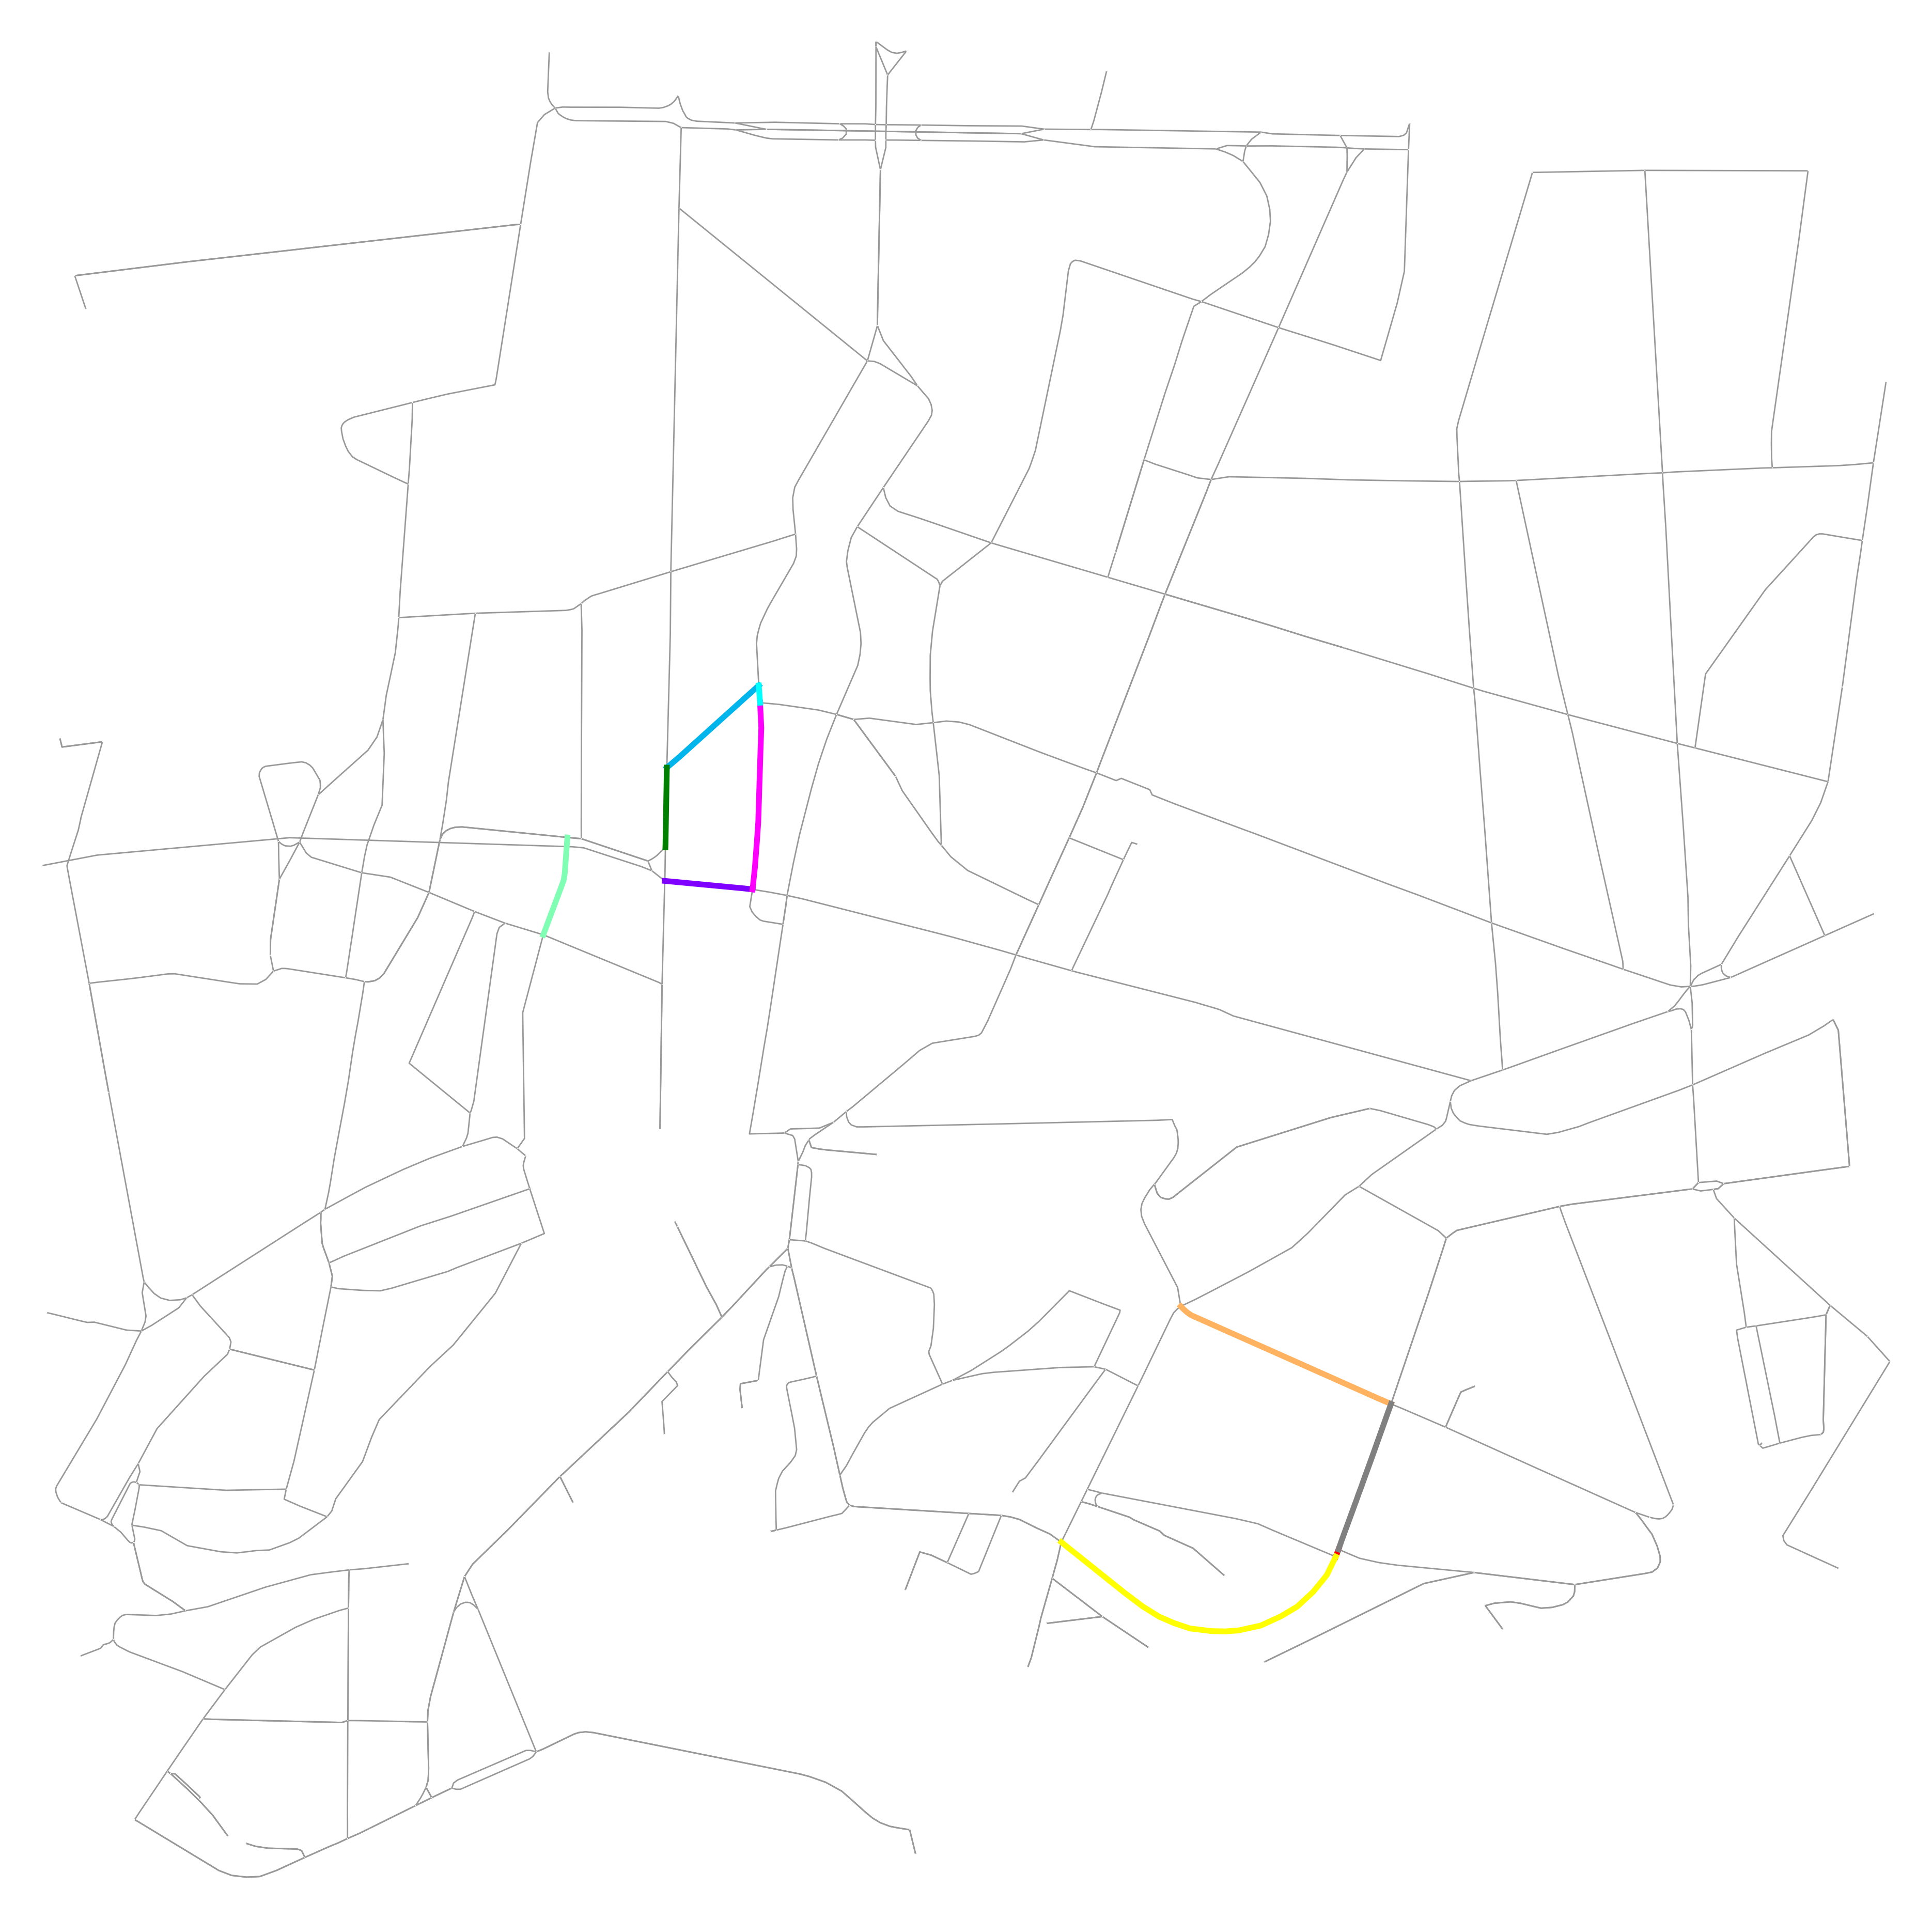

In [4]:
match_path = 'data/matched_routines.csv'
edge_path = 'data/porto/edges.shp'

df = load_and_preprocess_data(match_path)
road_segments = extract_road_segments(df)
most_common_segments = get_most_common_segments(road_segments)

visualize_segments_on_map(edge_path, most_common_segments)

 (2) to return 10 road segments,
whose average travelling time as indicated by the trajectory data
are the largest (those road segments that are traversed by no
trajectories can be ignored);